In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= '2.0'
from tensorflow import keras

import numpy as np
import pandas as pd
import scipy
import os
import time

from constants import *
from data import CSVDataHandler

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [30]:
def plot_property(data_:pdSeries):
    fig = plt.figure(figsize = FIGURE_SIZE)
    ax = fig.add_subplot(1, 1, 1)
    ax.grid()
    plt.plot(data_)

In [3]:
import ta

In [4]:
%%time
bars = CSVDataHandler('data', TIMEFRAME_MIN15,
           {'UVXY': {'src': 'av', 'tz': 'US/Eastern', 'exn':True, 'file':'UVXY_daily.csv'}, 
            'IMOEX': {'src': 'finam', 'tz': 'Europe/Moscow'},
            'SPFB': {'src': 'finam', 'tz': 'Europe/Moscow', 'exn': False},
            'SI': {'src': 'finam', 'tz': 'Europe/Moscow', 'exn': False}
           })

Wall time: 9.03 s


In [6]:
m = 1*10**5
train_data = bars.all_bars('SPFB').iloc[:m, :]
print(train_data.shape[0])

100000


In [23]:
df = train_data.reset_index()
df.head()

,datetime,open,high,low,close,volume
0,2009-07-16 18:15:00+04:00,63.73,63.73,63.73,63.73,100.0
1,2009-07-16 18:45:00+04:00,64.09,64.14,64.09,64.14,4.0
2,2009-07-16 19:00:00+04:00,64.07,64.25,64.07,64.25,6.0
3,2009-07-16 19:30:00+04:00,64.10,64.10,63.96,63.96,304.0
4,2009-07-16 20:00:00+04:00,64.03,64.03,64.03,64.03,300.0


----
## Adding indicators

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [27]:
df.head()

,datetime,open,high,low,close,volume
0,2009-07-16 18:15:00+04:00,63.73,63.73,63.73,63.73,100.0
1,2009-07-16 18:45:00+04:00,64.09,64.14,64.09,64.14,4.0
2,2009-07-16 19:00:00+04:00,64.07,64.25,64.07,64.25,6.0
3,2009-07-16 19:30:00+04:00,64.10,64.10,63.96,63.96,304.0
4,2009-07-16 20:00:00+04:00,64.03,64.03,64.03,64.03,300.0


In [45]:
class MomentumIndicatorAdder(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        R = X.copy()
        R.loc[:, 'ao'] = ta.momentum.ao(X.high, X.low)
        R.loc[:, 'kama'] = ta.momentum.kama(X.close)
        R.loc[:, 'roc'] = ta.momentum.roc(X.close)
        R.loc[:, 'rsi'] = ta.momentum.rsi(X.close)
        R.loc[:, 'stoch'] = ta.momentum.stoch(X.high, X.low, X.close)
        R.loc[:, 'stoch_signal'] = ta.momentum.stoch_signal(X.high, X.low, X.close)
        R.loc[:, 'tsi'] = ta.momentum.tsi(X.close)
        R.loc[:, 'uo'] = ta.momentum.uo(X.high, X.low, X.close)
        R.loc[:, 'wr'] = ta.momentum.wr(X.high, X.low, X.close)
        return R

In [46]:
feature_pipeline = Pipeline([
        ('momentum', MomentumIndicatorAdder()),
        #('volatility', VolatilityIndicatorAdder()),
    ])

df_features = feature_pipeline.fit_transform(df)
df_features[100:150]

,datetime,open,high,low,close,volume,ao,kama,roc,rsi,stoch,stoch_signal,tsi,uo,wr
100,2009-07-24 23:00:00+04:00,70.74,70.74,70.74,70.74,1.0,1.040706,70.218117,0.468683,62.023874,80.165289,8.953168e+01,25.836074,64.503100,-19.834711
101,2009-07-24 23:15:00+04:00,70.82,70.82,70.82,70.82,1.0,1.080824,70.250416,0.868822,62.928067,86.776860,8.512397e+01,25.836037,69.564778,-13.223140
102,2009-07-27 10:45:00+04:00,71.66,71.83,71.66,71.80,13.0,1.155147,70.545061,2.732866,71.789157,98.543689,8.849528e+01,28.908704,73.942725,-1.456311
103,2009-07-27 11:00:00+04:00,71.70,71.70,71.70,71.70,1.0,1.191206,70.713732,2.297047,69.951776,93.689320,9.300329e+01,30.717968,76.455436,-6.310680
104,2009-07-27 11:15:00+04:00,71.77,71.77,71.72,71.72,3.0,1.263529,70.909080,2.794898,70.116511,94.660194,9.563107e+01,32.192842,72.449494,-5.339806
105,2009-07-27 11:45:00+04:00,71.58,71.58,71.58,71.58,30.0,1.333588,70.987585,2.154988,67.333706,87.864078,9.207120e+01,32.589107,66.097466,-12.135922
106,2009-07-27 12:45:00+04:00,71.63,71.63,71.63,71.63,1.0,1.389412,71.104062,2.489627,67.824851,89.690722,9.073833e+01,33.052799,71.860850,-10.309278
107,2009-07-27 14:00:00+04:00,71.56,71.56,71.56,71.56,1.0,1.239471,71.146398,1.647727,66.321444,86.082474,8.787909e+01,33.026724,71.185566,-13.917526
108,2009-07-27 18:15:00+04:00,71.64,71.64,71.64,71.64,1.0,1.144235,71.188002,2.065821,67.215837,88.414634,8.806261e+01,33.243776,72.494566,-11.585366
109,2009-07-27 18:30:00+04:00,71.11,71.11,71.11,71.11,5.0,0.956500,71.186470,0.395313,56.508959,56.097561,7.686489e+01,30.257480,33.393802,-43.902439


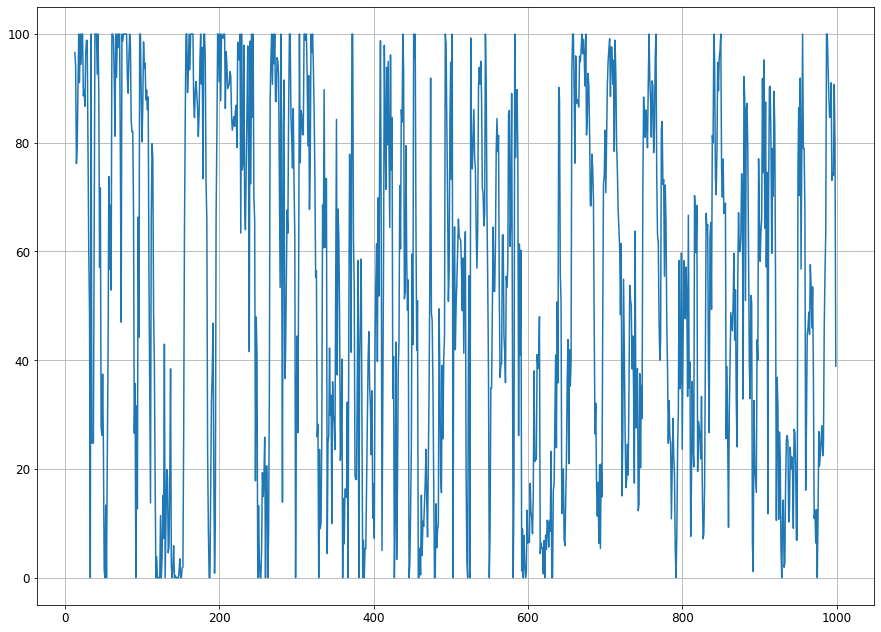

In [41]:
plot_property(df_features.stoch[:1000])

----
## Debug

In [8]:
# Initialize Bollinger Bands Indicator
indicator_bb = ta.volatility.BollingerBands(close=df.close, n=20, ndev=2)

# Add Bollinger Bands features
df['bb_bbm'] = indicator_bb.bollinger_mavg()
df['bb_bbh'] = indicator_bb.bollinger_hband()
df['bb_bbl'] = indicator_bb.bollinger_lband()

# Add Bollinger Band high indicator
df['bb_bbhi'] = indicator_bb.bollinger_hband_indicator()

# Add Bollinger Band low indicator
df['bb_bbli'] = indicator_bb.bollinger_lband_indicator()

In [11]:
df[125:175]

,datetime,open,high,low,close,volume,bb_bbm,bb_bbh,bb_bbl,bb_bbhi,bb_bbli
125,2009-07-28 19:45:00+04:00,69.68,69.68,69.68,69.68,1.0,70.9160,72.248507,69.583493,0.0,0.0
126,2009-07-28 20:00:00+04:00,69.75,69.75,69.75,69.75,10.0,70.8220,72.204094,69.439906,0.0,0.0
127,2009-07-28 20:45:00+04:00,69.97,69.97,69.97,69.97,1.0,70.7425,72.128557,69.356443,0.0,0.0
128,2009-07-28 21:15:00+04:00,69.80,69.80,69.80,69.80,20.0,70.6505,72.030304,69.270696,0.0,0.0
129,2009-07-28 22:00:00+04:00,70.35,70.35,70.35,70.35,1.0,70.6125,71.981410,69.243590,0.0,0.0
130,2009-07-29 10:45:00+04:00,69.49,69.55,68.97,68.97,351.0,70.5045,72.025440,68.983560,0.0,1.0
131,2009-07-29 11:00:00+04:00,69.16,69.16,69.16,69.16,1.0,70.4180,72.035141,68.800859,0.0,0.0
132,2009-07-29 11:15:00+04:00,69.35,69.36,69.35,69.36,4.0,70.3130,71.918542,68.707458,0.0,0.0
133,2009-07-29 11:45:00+04:00,69.32,69.32,69.32,69.32,2.0,70.1985,71.743198,68.653802,0.0,0.0
134,2009-07-29 12:45:00+04:00,69.05,69.05,69.05,69.05,25.0,70.0710,71.551553,68.590447,0.0,0.0
